2025-11-01 09:15:26,655 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


📦 Loading Claude results from: C:\Users\Boris\Desktop\code\multilingual-rag\results\claude_ablation\multilingual_rag_results_claude.csv
✓ Loaded 60 rows
✅ Data normalized for Hindi/Chinese + Claude format
Hindi results: 30
Chinese results: 30


2025-11-01 09:15:29,159 - INFO - Use pytorch device_name: cpu
2025-11-01 09:15:29,179 - INFO - Using default tokenizer.


✓ Initialized enhanced evaluator with model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Evaluating 30 Hindi questions...

[1/30] इंसुलिन प्रतिरोध क्या है और यह कोशिकाओं में ग्लूकोज के प्रवे...
  Semantic similarity: 0.933
  ROUGE-L: 0.316
  Time speedup: 0.99x

[2/30] हृदय रोग के जोखिम पर पारिवारिक इतिहास का क्या प्रभाव पड़ता ह...
  Semantic similarity: 0.969
  ROUGE-L: 0.478
  Time speedup: 0.13x

[3/30] धूम्रपान का रक्तचाप और हृदय रोग के जोखिम पर क्या प्रभाव पड़त...
  Semantic similarity: 0.877
  ROUGE-L: 0.360
  Time speedup: 0.79x

[4/30] हृदय रोग के कौन से जोखिम कारक बदले जा सकते हैं?...
  Semantic similarity: 0.930
  ROUGE-L: 0.475
  Time speedup: 0.82x

[5/30] विभिन्न जातीय समूहों में हृदय रोग की दरों में क्या अंतर हैं?...
  Semantic similarity: 0.927
  ROUGE-L: 0.432
  Time speedup: 0.98x

[6/30] शराब के सेवन का हृदय रोग के जोखिम पर क्या प्रभाव पड़ता है?...
  Semantic similarity: 0.865
  ROUGE-L: 0.443
  Time speedup: 0.65x

[7/30] अतिरिक्त कैलोरी का हृदय रोग 

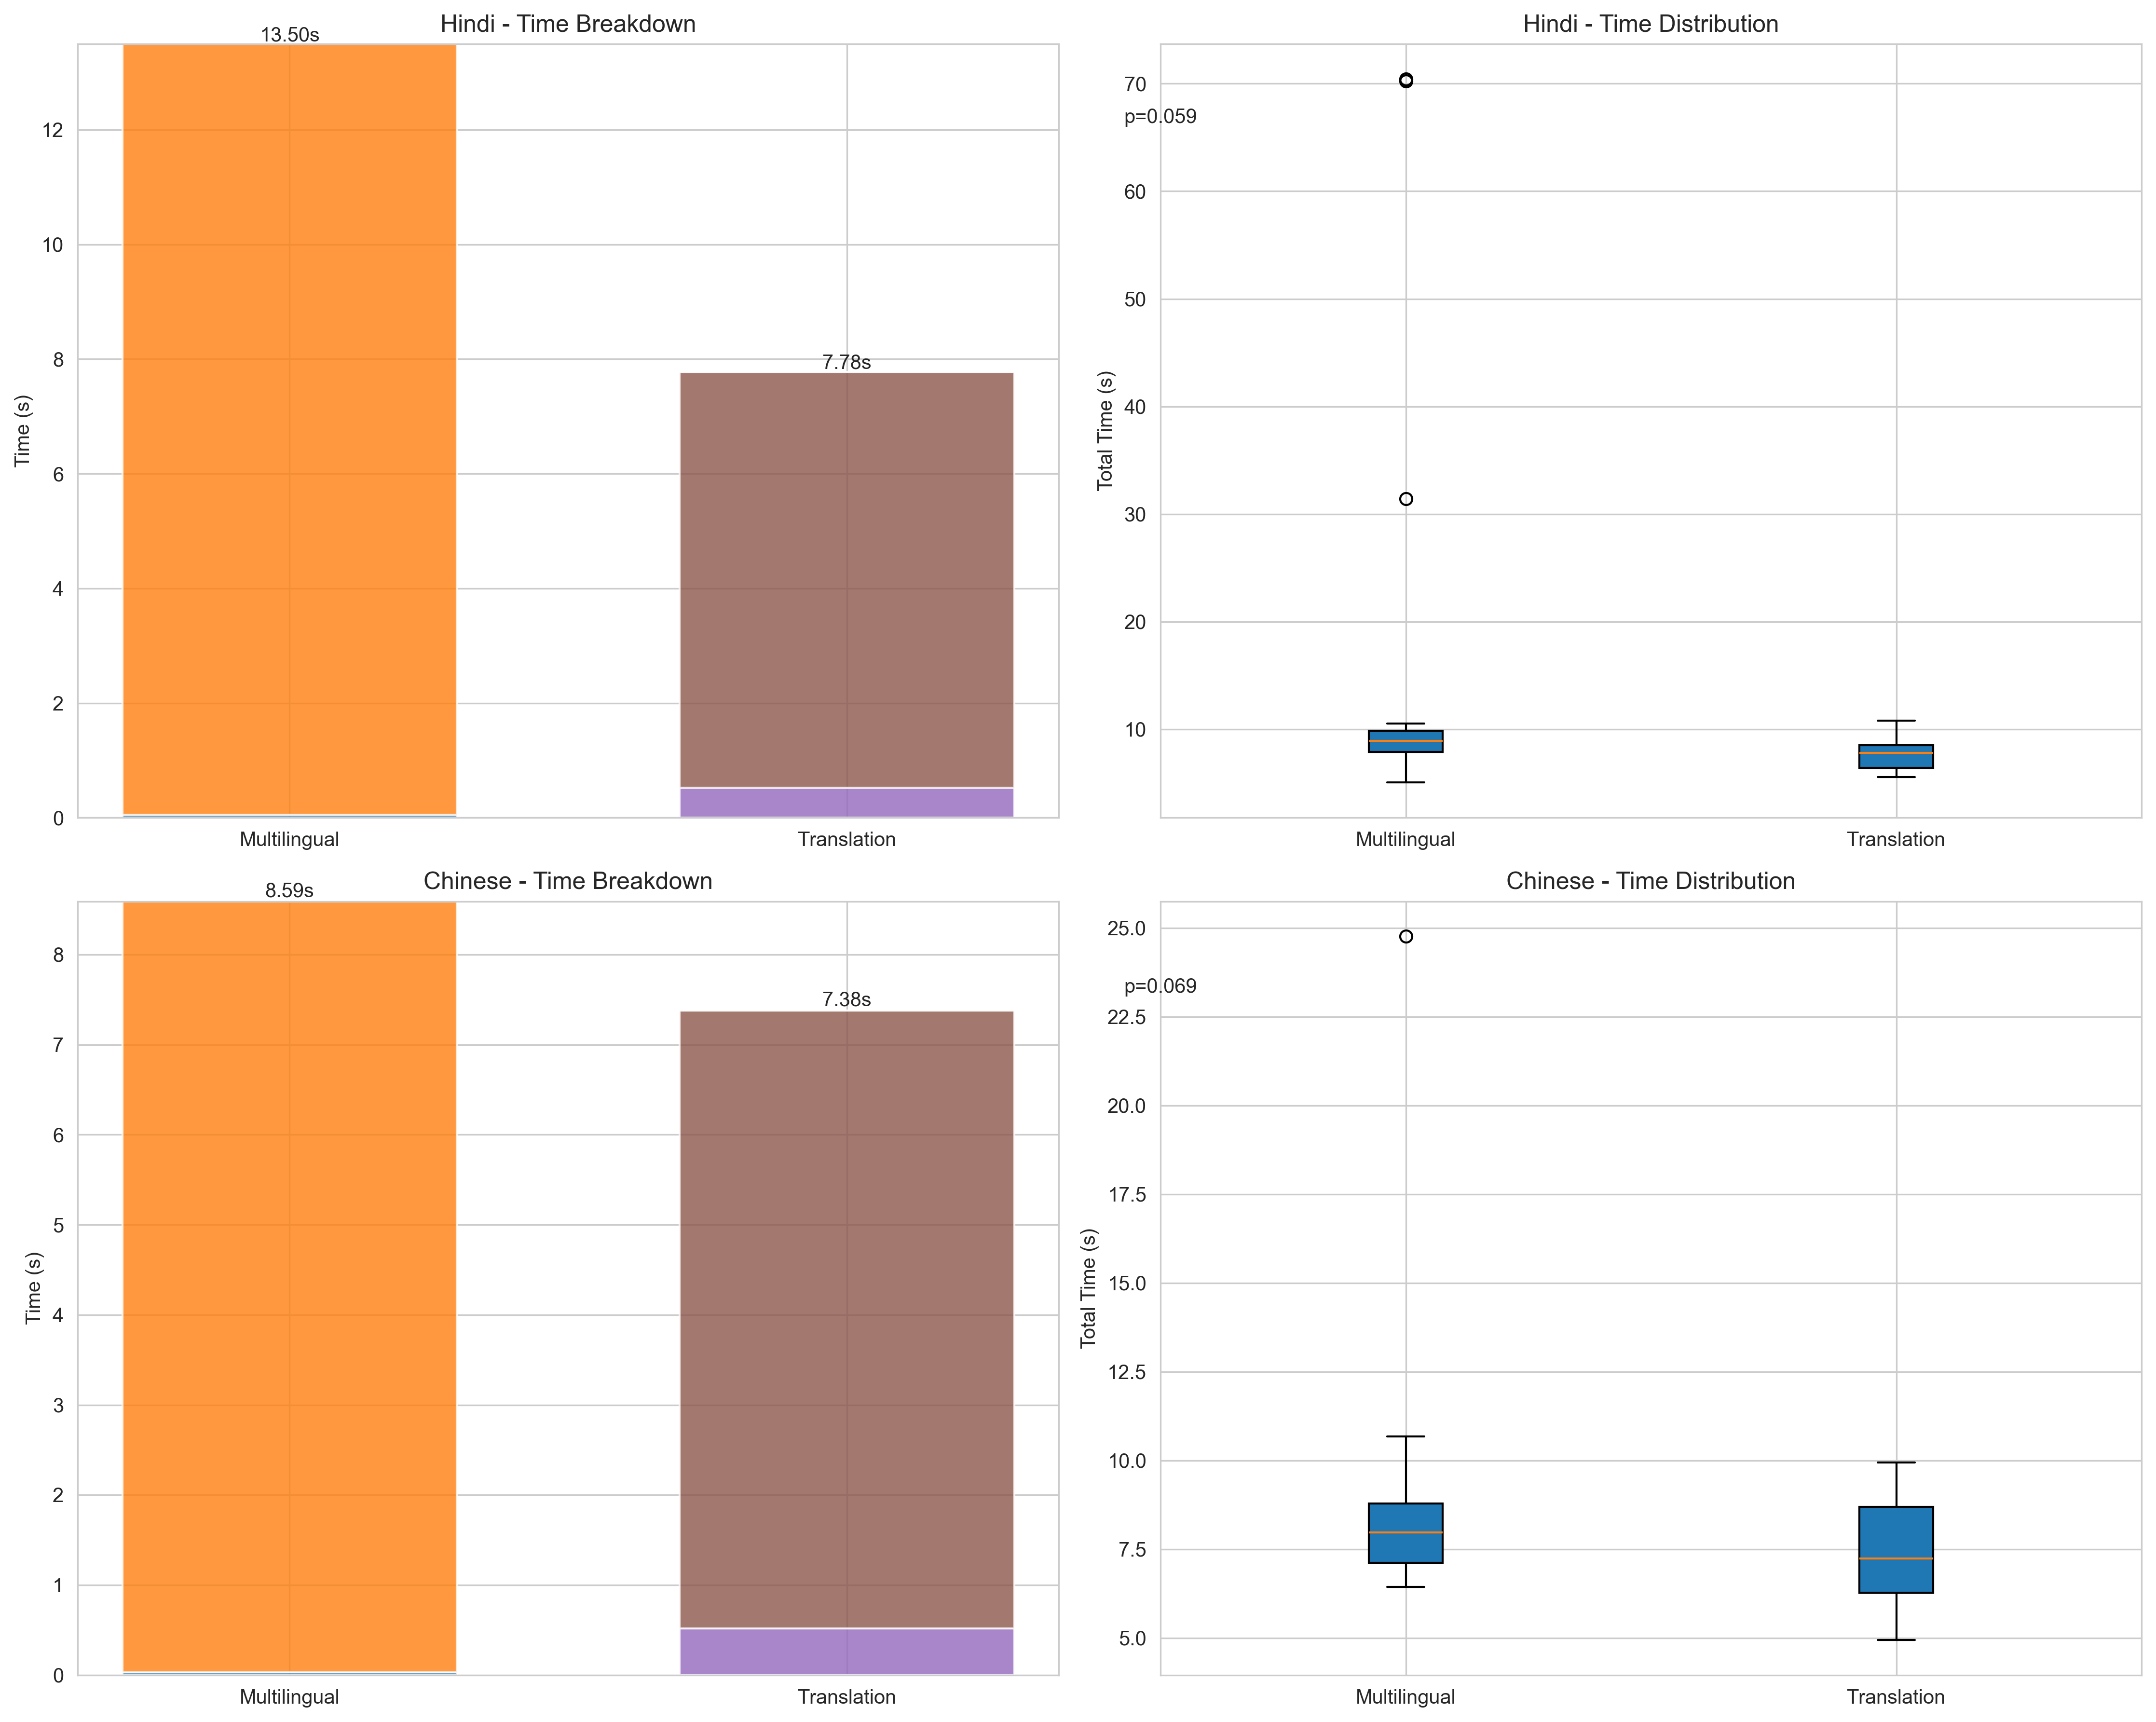

✓ Saved to C:\Users\Boris\Desktop\code\multilingual-rag\results\claude_ablation\enhanced_figures\quality_metrics_per_language.png


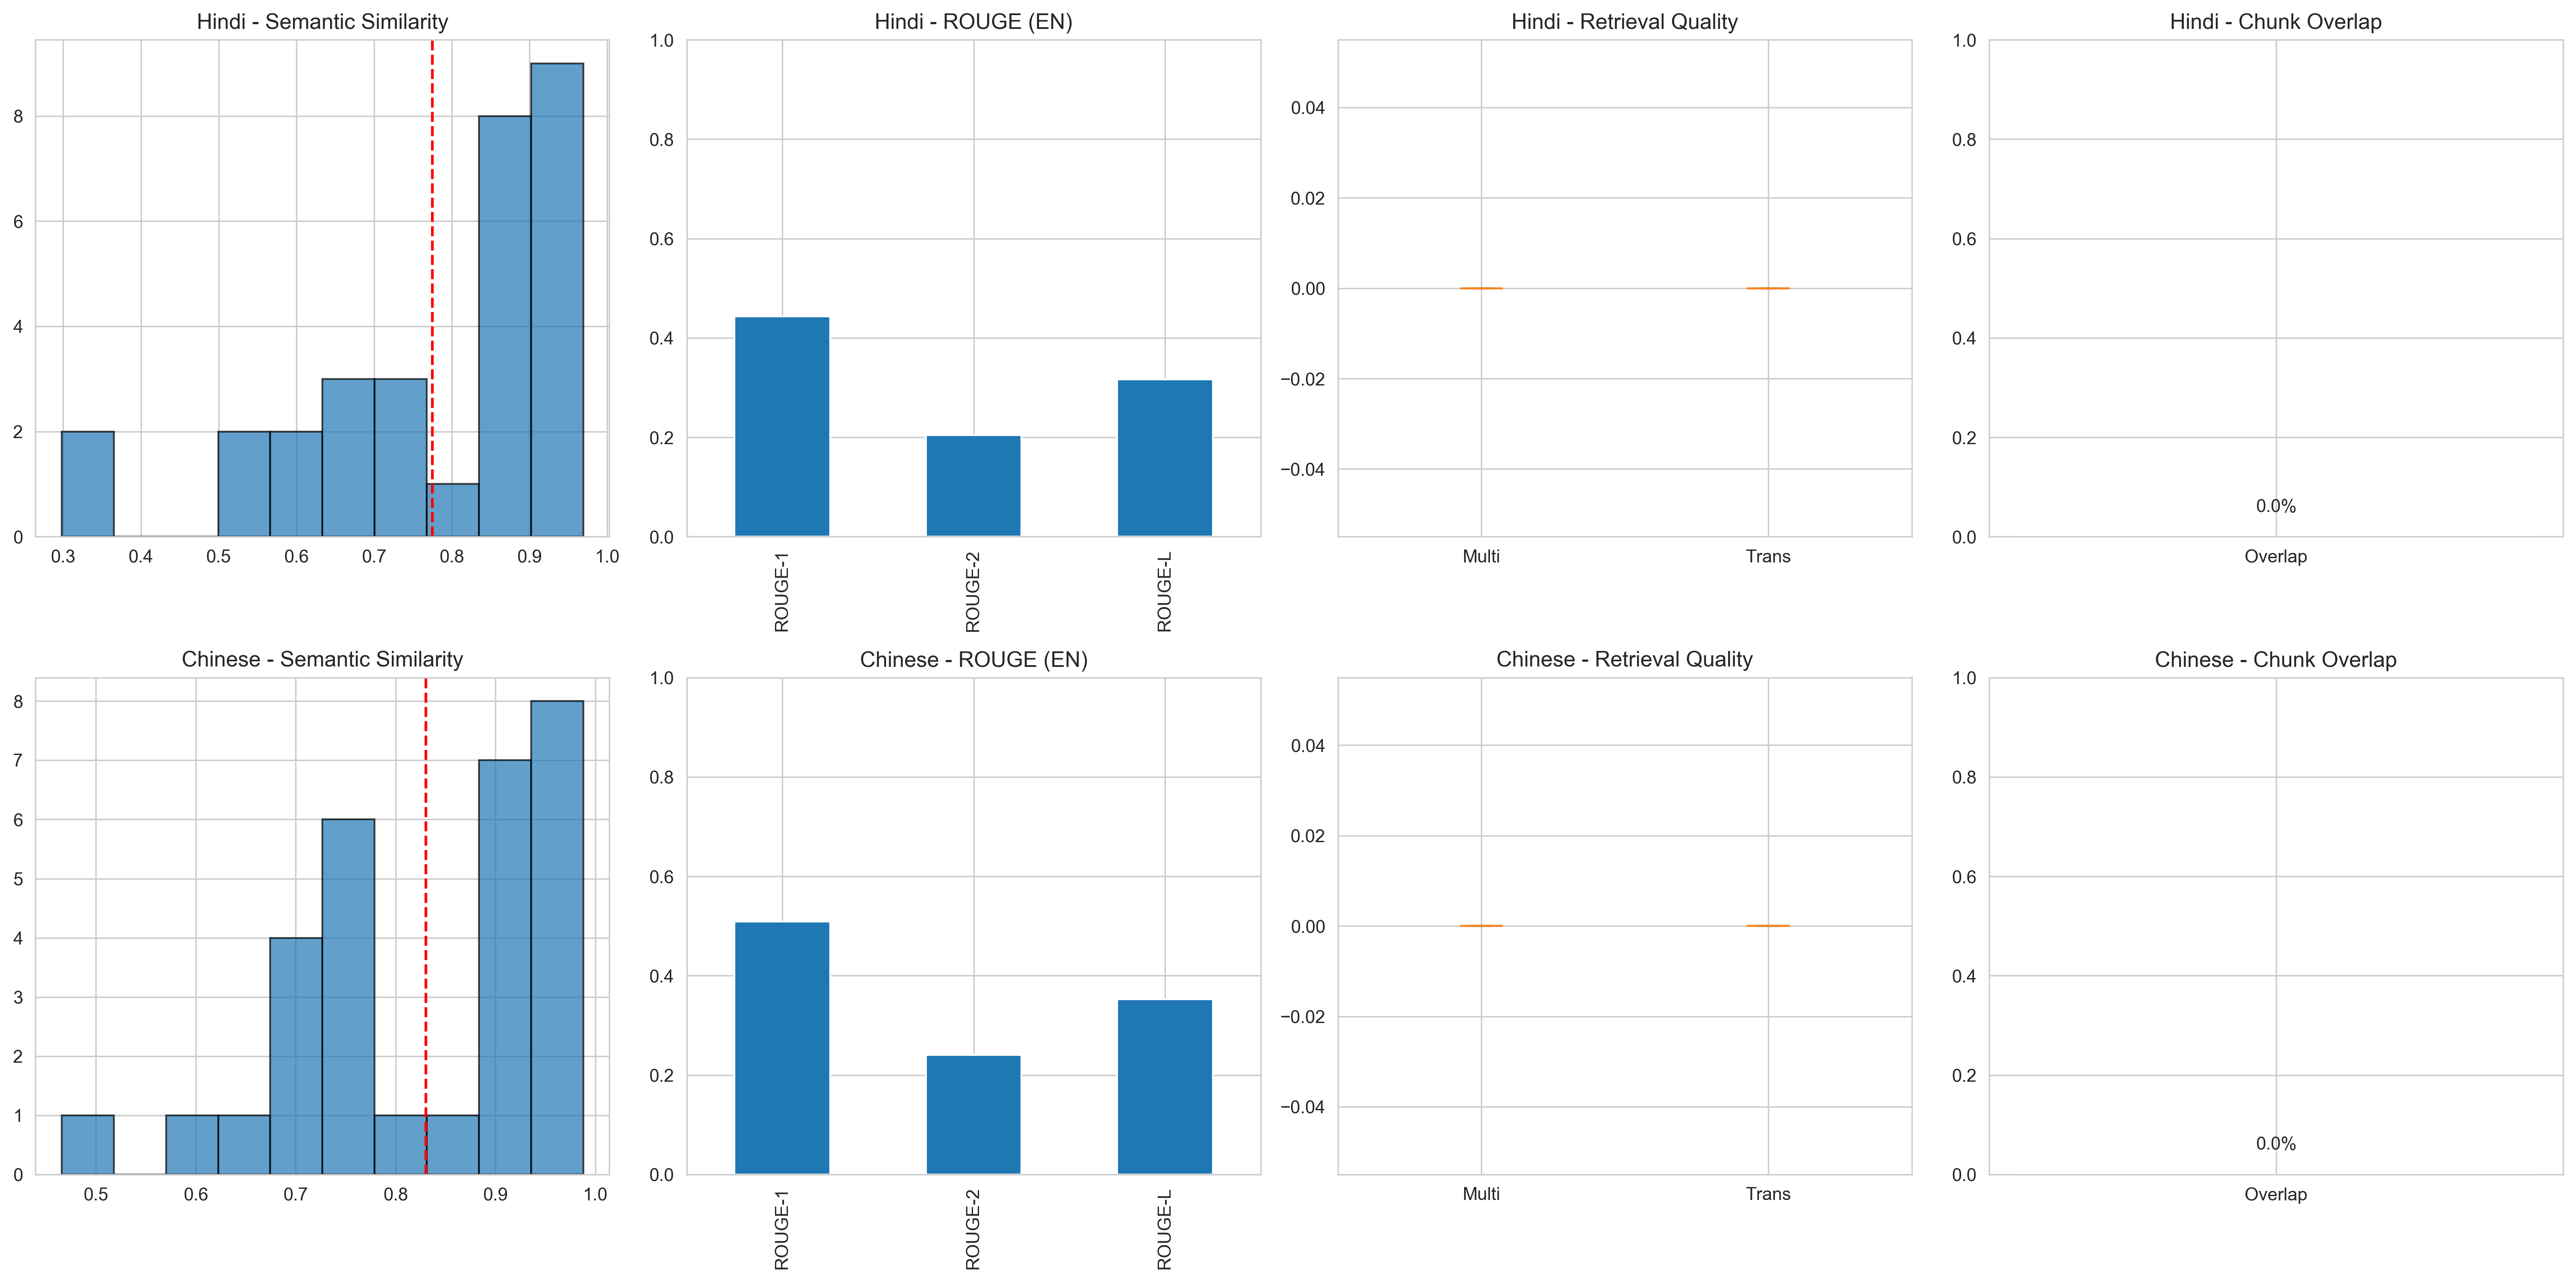

✓ Saved to C:\Users\Boris\Desktop\code\multilingual-rag\results\claude_ablation\enhanced_figures\cross_language_comparison.png


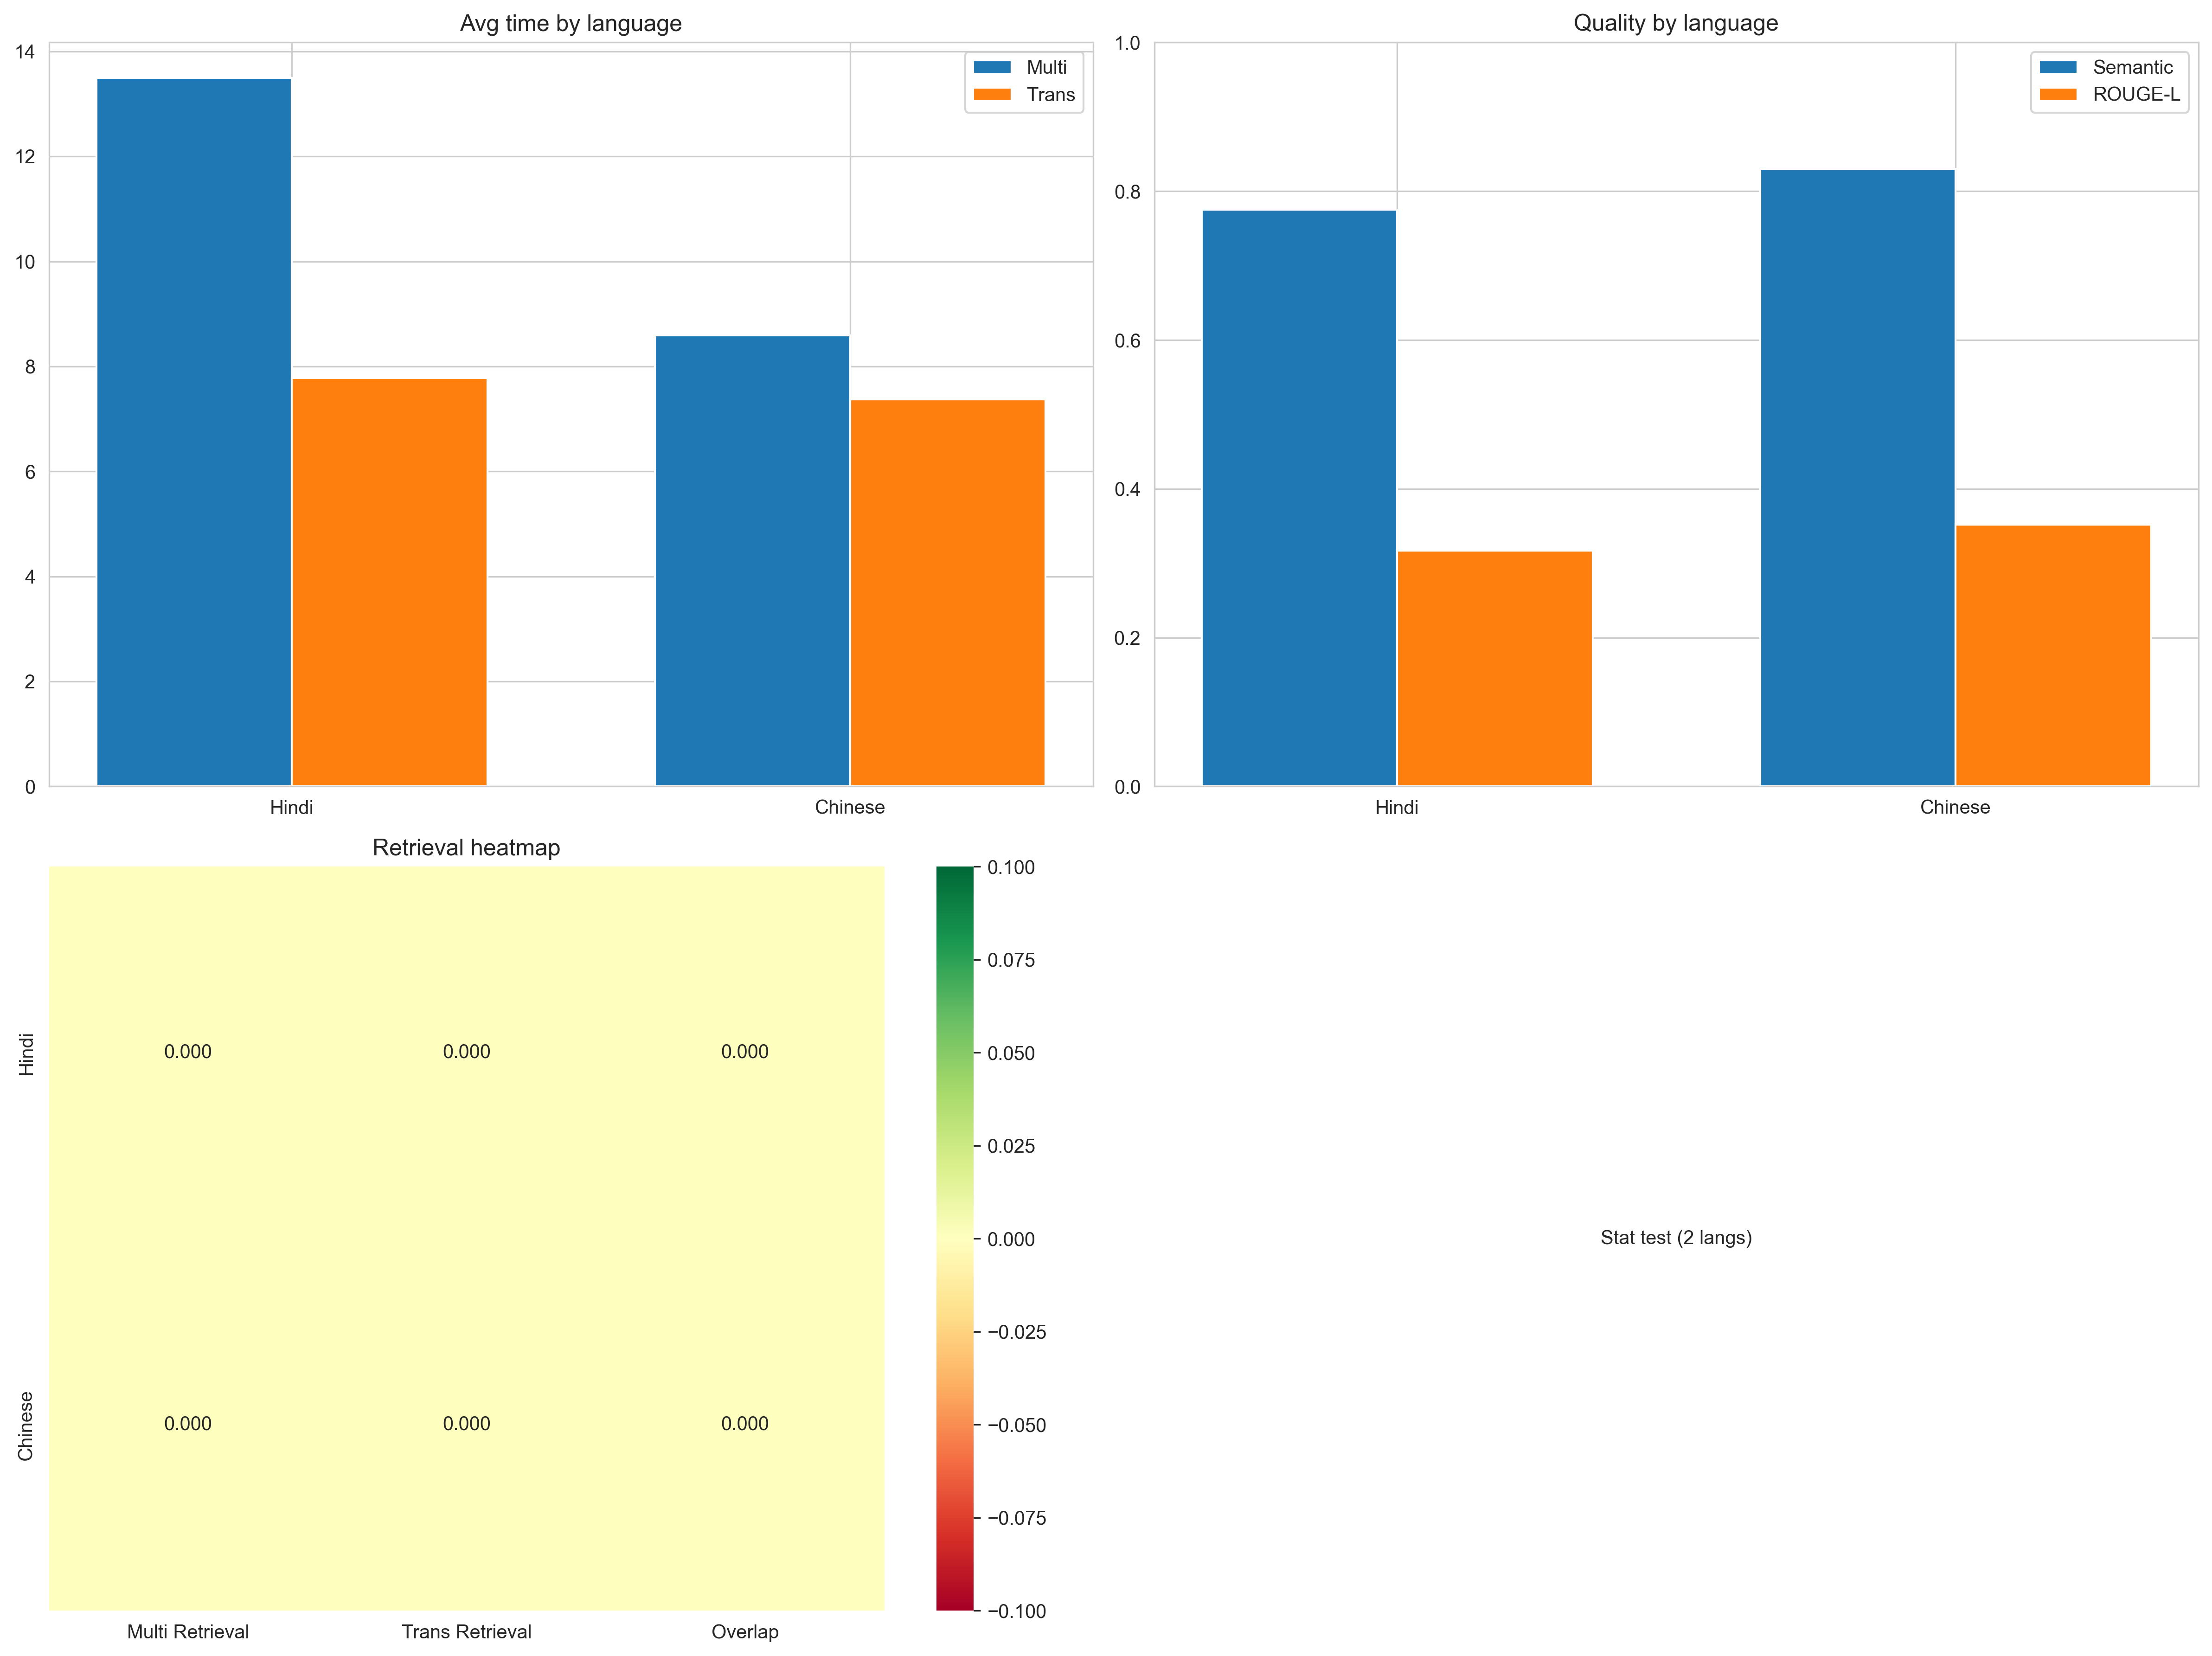

✓ Saved to C:\Users\Boris\Desktop\code\multilingual-rag\results\claude_ablation\enhanced_figures\chunk_overlap_analysis.png


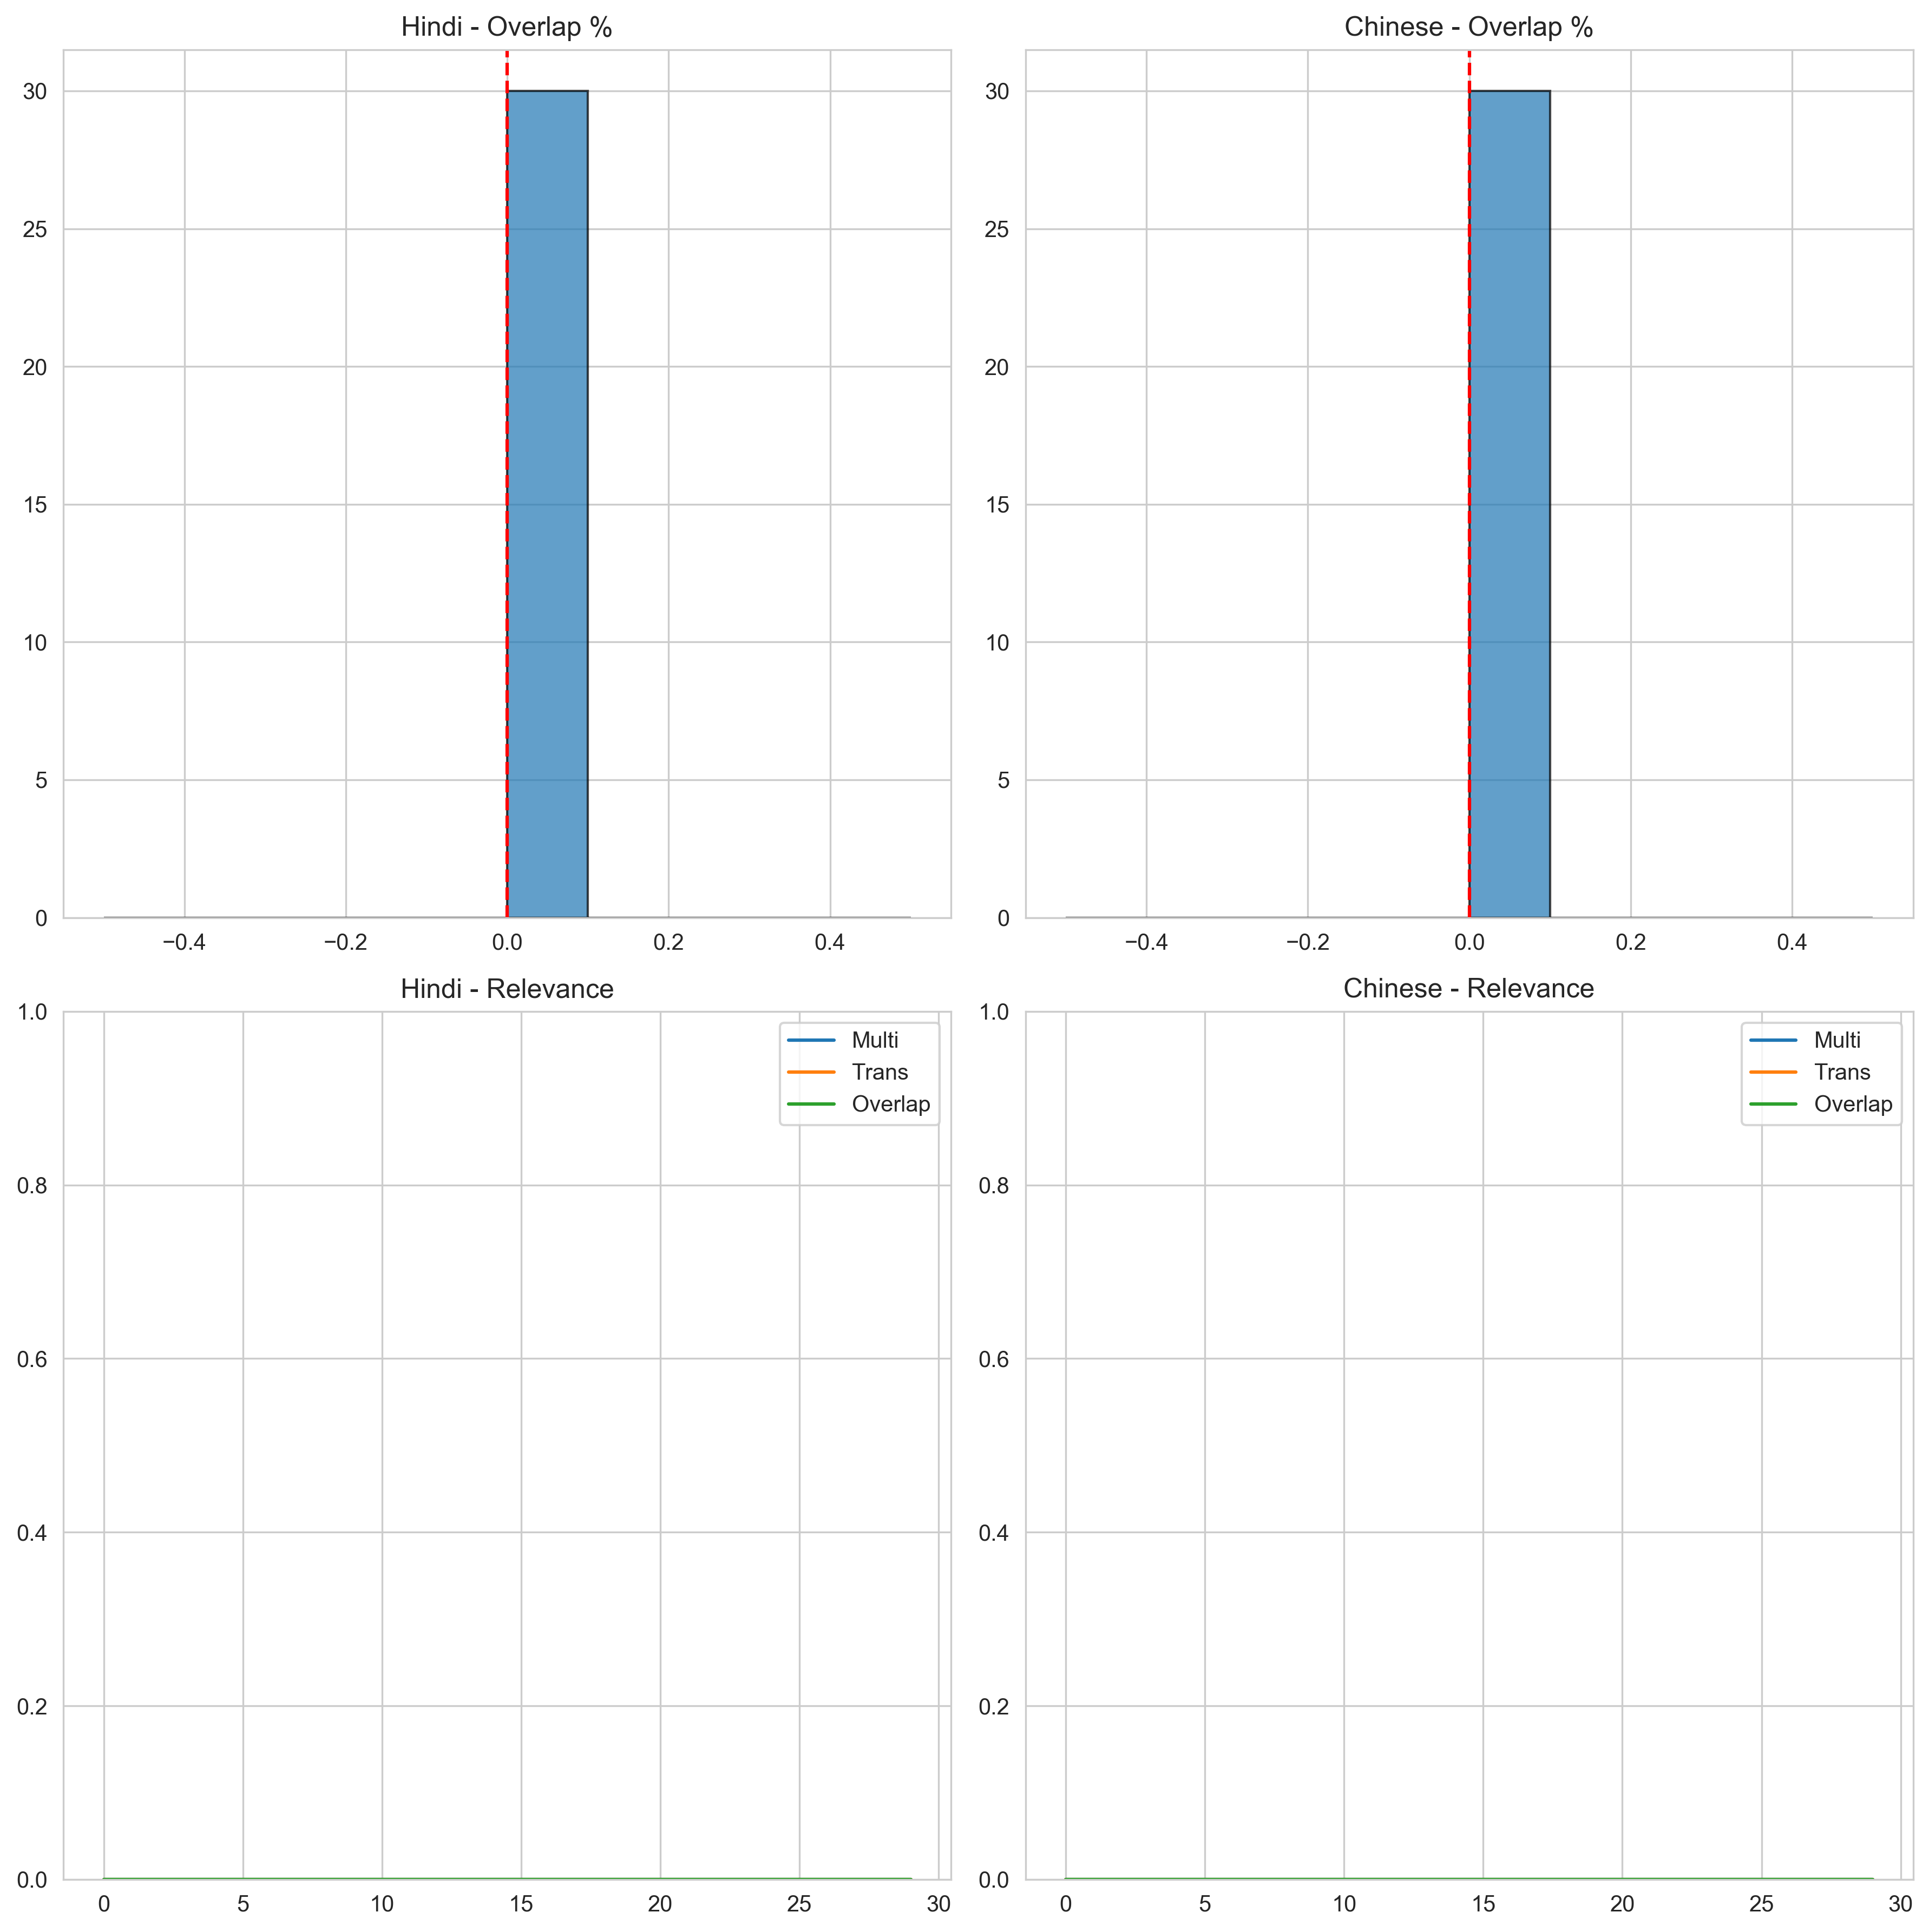


COMPREHENSIVE STATISTICAL REPORT
Language              Metric    Multilingual   Translation P-value      Winner
   Hindi  Avg Total Time (s) 13.497 ± 16.049 7.780 ± 1.512  0.0589 Translation
   Hindi Avg Retrieval Score           0.000         0.000     nan Translation
 Chinese  Avg Total Time (s)   8.590 ± 3.271 7.376 ± 1.484  0.0690 Translation
 Chinese Avg Retrieval Score           0.000         0.000     nan Translation
✓ Saved statistical report to C:\Users\Boris\Desktop\code\multilingual-rag\results\claude_ablation\enhanced_figures\enhanced_statistical_report.csv

ENHANCED ANALYSIS COMPLETE (CLAUDE)


In [1]:
# ============================================================
# Notebook 4 (UPDATED): Enhanced Multilingual RAG Evaluation
# for Claude Ablation Results (Hindi + Chinese)
#
# This version is aligned with Notebook 3, which saved:
#   ../results/claude_ablation/multilingual_rag_results_claude.csv
# and used lowercase language names.
#
# ============================================================

import sys
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Any
import logging
import warnings

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from scipy import stats

# nltk (quiet)
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ------------------------------------------------------------
# GLOBAL CONFIG
# ------------------------------------------------------------
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("notebook_4_claude_eval")

# ------------------------------------------------------------
# 1. LOAD CLAUDE RESULTS FROM NOTEBOOK 3
# ------------------------------------------------------------
ROOT_DIR = Path('..').resolve()
RESULTS_DIR = ROOT_DIR / 'results'
CLAUDE_DIR = RESULTS_DIR / 'claude_ablation'
results_file = CLAUDE_DIR / 'multilingual_rag_results_claude.csv'

if not results_file.exists():
    raise FileNotFoundError(f"❌ Expected file not found: {results_file}")
else:
    print(f"📦 Loading Claude results from: {results_file}")
    df_results = pd.read_csv(results_file, encoding='utf-8')
    print(f"✓ Loaded {len(df_results)} rows")

# ------------------------------------------------------------
# 2. NORMALIZE / PATCH COLUMNS TO WHAT THIS NB EXPECTS
# ------------------------------------------------------------

# 2.1 normalize language labels
df_results['language'] = df_results['language'].replace({
    'hindi': 'Hindi',
    'Hindi': 'Hindi',
    'chinese': 'Chinese',
    'Chinese': 'Chinese'
})

# 2.2 ensure question_id exists
if 'question_id' not in df_results.columns:
    df_results['question_id'] = np.arange(1, len(df_results) + 1)

# 2.3 time columns from notebook 3
# NB3 saved:
#   - multilingual_time
#   - translation_time
#   - retrieval_time_multi
#   - retrieval_time_trans
#   - generation_time_multi
#   - generation_time_trans
if 'multilingual_time' in df_results.columns:
    df_results['multilingual_total_time'] = df_results['multilingual_time']
else:
    df_results['multilingual_total_time'] = 0.0

if 'translation_time' in df_results.columns:
    df_results['translation_total_time'] = df_results['translation_time']
else:
    df_results['translation_total_time'] = 0.0

# component times – fill from whatever NB3 produced, else 0
df_results['multilingual_retrieval_time'] = df_results.get('retrieval_time_multi', 0.0)
df_results['multilingual_generation_time'] = df_results.get('generation_time_multi', 0.0)
# Claude multilingual pipeline usually didn't translate response → leave 0
df_results['multilingual_response_translation_time'] = df_results.get('multilingual_response_translation_time', 0.0)

df_results['translation_question_translation_time'] = df_results.get('translation_question_translation_time', 0.0)
df_results['translation_retrieval_time'] = df_results.get('retrieval_time_trans', 0.0)
df_results['translation_generation_time'] = df_results.get('generation_time_trans', 0.0)
df_results['translation_response_translation_time'] = df_results.get('translation_response_translation_time', 0.0)

# 2.4 retrieved chunks – NB3 saved these names
if 'multilingual_chunks' in df_results.columns:
    df_results['multilingual_retrieved_chunks'] = df_results['multilingual_chunks']
elif 'multilingual_retrieved_chunks' not in df_results.columns:
    df_results['multilingual_retrieved_chunks'] = "[]"

if 'translation_chunks' in df_results.columns:
    df_results['translation_retrieved_chunks'] = df_results['translation_chunks']
elif 'translation_retrieved_chunks' not in df_results.columns:
    df_results['translation_retrieved_chunks'] = "[]"

# 2.5 english-for-eval – NB3 saved:
#     - multilingual_english
#     - translation_english
if 'multilingual_english' in df_results.columns:
    df_results['multilingual_response_english_for_eval'] = df_results['multilingual_english']
elif 'multilingual_response_english_for_eval' not in df_results.columns:
    df_results['multilingual_response_english_for_eval'] = ""

if 'translation_english' in df_results.columns:
    df_results['translation_response_english_for_eval'] = df_results['translation_english']
elif 'translation_response_english_for_eval' not in df_results.columns:
    df_results['translation_response_english_for_eval'] = ""

# 2.6 chunk scores / sources – NB3 probably didn’t save → create empty
for col in [
    'multilingual_chunk_scores',
    'translation_chunk_scores',
    'multilingual_chunk_sources',
    'translation_chunk_sources'
]:
    if col not in df_results.columns:
        df_results[col] = "[]"

print("✅ Data normalized for Hindi/Chinese + Claude format")

# ------------------------------------------------------------
# 3. SPLIT BY LANGUAGE
# ------------------------------------------------------------
df_hindi = df_results[df_results['language'] == 'Hindi'].copy()
df_chinese = df_results[df_results['language'] == 'Chinese'].copy()

print(f"Hindi results: {len(df_hindi)}")
print(f"Chinese results: {len(df_chinese)}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

# ============================================================
# 4. EVALUATOR CLASSES
# ============================================================

class EnhancedMultilingualRAGEvaluator:
    """
    Enhanced evaluation for cross-lingual RAG systems with deep analysis.
    Works directly with the columns produced by the Claude ablation run.
    """
    def __init__(self, multilingual_model: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        self.multilingual_encoder = SentenceTransformer(multilingual_model)
        # turn off progress
        self.multilingual_encoder.encode = self._encode_without_progress
        self.rouge_scorer_obj = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True
        )
        print(f"✓ Initialized enhanced evaluator with model: {multilingual_model}")

    def _encode_without_progress(self, sentences, **kwargs):
        kwargs['show_progress_bar'] = False
        return SentenceTransformer.encode(self.multilingual_encoder, sentences, **kwargs)

    def calculate_multilingual_semantic_similarity(self, text1: str, text2: str) -> float:
        embeddings = self.multilingual_encoder.encode([text1, text2])
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        return float(similarity)

    def calculate_rouge_on_translated(self, text1_english: str, text2_english: str) -> Dict[str, float]:
        scores = self.rouge_scorer_obj.score(text1_english, text2_english)
        return {
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
        }

    def _parse_list(self, data):
        if isinstance(data, str):
            try:
                return eval(data)
            except Exception:
                return []
        elif isinstance(data, list):
            return data
        else:
            return []

    def evaluate_retrieval_quality(self, chunk_scores_1: List[float], chunk_scores_2: List[float],
                                   sources_1: List[str], sources_2: List[str]) -> Dict[str, float]:
        result = {}
        chunk_scores_1 = self._parse_list(chunk_scores_1)
        chunk_scores_2 = self._parse_list(chunk_scores_2)
        sources_1 = self._parse_list(sources_1)
        sources_2 = self._parse_list(sources_2)

        try:
            chunk_scores_1 = [float(x) for x in chunk_scores_1 if x]
        except Exception:
            chunk_scores_1 = []

        try:
            chunk_scores_2 = [float(x) for x in chunk_scores_2 if x]
        except Exception:
            chunk_scores_2 = []

        if chunk_scores_1:
            result['avg_similarity_score_1'] = float(np.mean(chunk_scores_1))
            result['min_similarity_score_1'] = float(np.min(chunk_scores_1))
        else:
            result['avg_similarity_score_1'] = 0.0
            result['min_similarity_score_1'] = 0.0

        if chunk_scores_2:
            result['avg_similarity_score_2'] = float(np.mean(chunk_scores_2))
            result['min_similarity_score_2'] = float(np.min(chunk_scores_2))
        else:
            result['avg_similarity_score_2'] = 0.0
            result['min_similarity_score_2'] = 0.0

        result['unique_sources_1'] = len(set(sources_1)) if sources_1 else 0
        result['unique_sources_2'] = len(set(sources_2)) if sources_2 else 0

        if sources_1 and sources_2:
            overlap = len(set(sources_1) & set(sources_2))
            result['retrieval_overlap'] = overlap / max(len(sources_1), len(sources_2))
        else:
            result['retrieval_overlap'] = 0.0

        return result

    def evaluate_single_question(self, row: pd.Series, language: str) -> Dict[str, float]:
        results = {}

        response_multi = str(row.get('multilingual_response', ''))
        response_trans = str(row.get('translation_response', ''))
        response_multi_en = str(row.get('multilingual_response_english_for_eval', ''))
        response_trans_en = str(row.get('translation_response_english_for_eval', ''))

        # 1. semantic similarity (native)
        if response_multi and response_trans:
            results['semantic_similarity'] = self.calculate_multilingual_semantic_similarity(
                response_multi, response_trans
            )
        else:
            results['semantic_similarity'] = 0.0

        # 2. ROUGE on english
        if response_multi_en and response_trans_en:
            rouge_scores = self.calculate_rouge_on_translated(
                response_multi_en, response_trans_en
            )
            results.update(rouge_scores)
        else:
            results.update({
                'rouge1_f1': 0.0, 'rouge2_f1': 0.0, 'rougeL_f1': 0.0,
                'rouge1_precision': 0.0, 'rouge1_recall': 0.0,
                'rouge2_precision': 0.0, 'rouge2_recall': 0.0,
                'rougeL_precision': 0.0, 'rougeL_recall': 0.0,
            })

        # 3. retrieval quality
        chunk_scores_multi = row.get('multilingual_chunk_scores', [])
        chunk_scores_trans = row.get('translation_chunk_scores', [])
        sources_multi = row.get('multilingual_chunk_sources', [])
        sources_trans = row.get('translation_chunk_sources', [])

        retrieval_metrics = self.evaluate_retrieval_quality(
            chunk_scores_multi, chunk_scores_trans, sources_multi, sources_trans
        )

        for key, value in retrieval_metrics.items():
            if '_1' in key:
                new_key = key.replace('_1', '_multilingual')
            elif '_2' in key:
                new_key = key.replace('_2', '_translation')
            else:
                new_key = key
            results[new_key] = value

        # 4. time metrics
        results['time_multilingual'] = float(row.get('multilingual_total_time', 0.0))
        results['time_translation'] = float(row.get('translation_total_time', 0.0))
        results['time_difference'] = results['time_translation'] - results['time_multilingual']
        results['time_speedup'] = (
            results['time_translation'] / results['time_multilingual']
            if results['time_multilingual'] > 0 else 0.0
        )

        # component times
        results['multilingual_retrieval_time'] = float(row.get('multilingual_retrieval_time', 0.0))
        results['multilingual_generation_time'] = float(row.get('multilingual_generation_time', 0.0))
        results['multilingual_response_translation_time'] = float(row.get('multilingual_response_translation_time', 0.0))

        results['translation_question_translation_time'] = float(row.get('translation_question_translation_time', 0.0))
        results['translation_retrieval_time'] = float(row.get('translation_retrieval_time', 0.0))
        results['translation_generation_time'] = float(row.get('translation_generation_time', 0.0))
        results['translation_response_translation_time'] = float(row.get('translation_response_translation_time', 0.0))

        results['language'] = language
        return results

    def evaluate_dataset(self, df_results: pd.DataFrame, language: str, output_path: str = None) -> pd.DataFrame:
        evaluation_results = []

        print(f"\nEvaluating {len(df_results)} {language} questions...")
        print("=" * 80)

        for idx, row in df_results.iterrows():
            print(f"\n[{idx+1}/{len(df_results)}] {str(row.get('question', ''))[:60]}...")
            eval_result = {
                'question_id': row.get('question_id', idx + 1),
                'language': language,
                'question': row.get('question', ''),
                'question_english_reference': row.get('question_english_reference', ''),
            }

            metrics = self.evaluate_single_question(row, language)
            eval_result.update(metrics)

            print(f"  Semantic similarity: {metrics['semantic_similarity']:.3f}")
            print(f"  ROUGE-L: {metrics['rougeL_f1']:.3f}")
            print(f"  Time speedup: {metrics['time_speedup']:.2f}x")

            evaluation_results.append(eval_result)

        df_eval = pd.DataFrame(evaluation_results)

        if output_path:
            Path(output_path).parent.mkdir(parents=True, exist_ok=True)
            df_eval.to_csv(output_path, index=False, encoding='utf-8')
            print(f"\n✓ Saved {language} evaluation to {output_path}")

        self._print_summary(df_eval, language)
        return df_eval

    def _print_summary(self, df_eval: pd.DataFrame, language: str):
        print("\n" + "=" * 80)
        print(f"{language.upper()} EVALUATION SUMMARY")
        print("=" * 80)

        print(f"\n📊 Response Quality (Semantic Similarity):")
        print(f"  Average: {df_eval['semantic_similarity'].mean():.3f}")
        print(f"  Std Dev: {df_eval['semantic_similarity'].std():.3f}")

        print(f"\n📊 ROUGE-L:")
        print(f"  Average F1: {df_eval['rougeL_f1'].mean():.3f}")

        print(f"\n⏱ Time:")
        print(f"  Multilingual: {df_eval['time_multilingual'].mean():.2f}s")
        print(f"  Translation:  {df_eval['time_translation'].mean():.2f}s")

        print(f"\n🔍 Retrieval overlap: {df_eval['retrieval_overlap'].mean():.1%}")

        if df_eval['semantic_similarity'].mean() > 0.8:
            if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean():
                print("  🏆 RECOMMENDATION: Multilingual embeddings (similar quality, faster)")
            else:
                print("  🏆 RECOMMENDATION: Translation pipeline (similar quality)")
        else:
            print("  ⚠️ Responses differ more than expected – review per-question cases")


# ============================================================
# 5. DEEP CHUNK ANALYZER
# ============================================================

class DeepChunkAnalyzer:
    """
    Analyze chunk overlap and content differences between approaches.
    """
    def __init__(self, multilingual_encoder):
        self.multilingual_encoder = multilingual_encoder
        if hasattr(multilingual_encoder, 'encode'):
            self.multilingual_encoder.encode = self._encode_without_progress

    def _encode_without_progress(self, sentences, **kwargs):
        kwargs['show_progress_bar'] = False
        return SentenceTransformer.encode(self.multilingual_encoder, sentences, **kwargs)

    def _parse_list(self, data):
        if isinstance(data, str):
            try:
                return eval(data)
            except Exception:
                return []
        elif isinstance(data, list):
            return data
        else:
            return []

    def analyze_chunks_for_question(
        self,
        question_id: str,
        question: str,
        multi_chunks: List[str],
        trans_chunks: List[str],
        multi_sources: List[str],
        trans_sources: List[str],
        multi_scores: List[float],
        trans_scores: List[float]
    ) -> Dict[str, Any]:

        multi_set = set(multi_chunks) if multi_chunks else set()
        trans_set = set(trans_chunks) if trans_chunks else set()

        overlapping_chunks = multi_set & trans_set
        multi_only = multi_set - trans_set
        trans_only = trans_set - multi_set

        overlap_count = len(overlapping_chunks)
        total_unique = len(multi_set | trans_set)
        if multi_chunks and trans_chunks:
            overlap_rate = overlap_count / max(len(multi_chunks), len(trans_chunks))
        else:
            overlap_rate = 0.0

        def calculate_chunk_relevance(chunk: str, question: str) -> float:
            try:
                embeddings = self.multilingual_encoder.encode([chunk, question])
                similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
                return float(similarity)
            except Exception:
                return 0.0

        multi_relevance = [calculate_chunk_relevance(c, question) for c in multi_chunks] if multi_chunks else []
        trans_relevance = [calculate_chunk_relevance(c, question) for c in trans_chunks] if trans_chunks else []
        overlapping_relevance = [calculate_chunk_relevance(c, question) for c in overlapping_chunks]
        multi_only_relevance = [calculate_chunk_relevance(c, question) for c in multi_only]
        trans_only_relevance = [calculate_chunk_relevance(c, question) for c in trans_only]

        return {
            'question_id': question_id,
            'question': question,
            'overlap_count': overlap_count,
            'overlap_rate': overlap_rate,
            'total_unique_chunks': total_unique,
            'multi_chunk_count': len(multi_chunks) if multi_chunks else 0,
            'trans_chunk_count': len(trans_chunks) if trans_chunks else 0,
            'multi_only_count': len(multi_only),
            'trans_only_count': len(trans_only),
            'overlapping_chunks': list(overlapping_chunks),
            'multi_only_chunks': list(multi_only),
            'trans_only_chunks': list(trans_only),
            'multi_sources': multi_sources or [],
            'trans_sources': trans_sources or [],
            'multi_scores': multi_scores or [],
            'trans_scores': trans_scores or [],
            'multi_avg_relevance': float(np.mean(multi_relevance)) if multi_relevance else 0.0,
            'trans_avg_relevance': float(np.mean(trans_relevance)) if trans_relevance else 0.0,
            'overlapping_avg_relevance': float(np.mean(overlapping_relevance)) if overlapping_relevance else 0.0,
            'multi_only_avg_relevance': float(np.mean(multi_only_relevance)) if multi_only_relevance else 0.0,
            'trans_only_avg_relevance': float(np.mean(trans_only_relevance)) if trans_only_relevance else 0.0,
            'multi_best_chunk_relevance': max(multi_relevance) if multi_relevance else 0.0,
            'trans_best_chunk_relevance': max(trans_relevance) if trans_relevance else 0.0,
        }

    def analyze_all_chunks(self, df_results: pd.DataFrame, df_evaluation: pd.DataFrame, language: str) -> pd.DataFrame:
        chunk_analyses = []
        print(f"\n{'='*80}")
        print(f"DEEP CHUNK ANALYSIS - {language.upper()}")
        print(f"{'='*80}")

        for idx, row in df_results.iterrows():
            qid = row['question_id']
            question = row['question']

            multi_chunks = self._parse_list(row.get('multilingual_retrieved_chunks', []))
            trans_chunks = self._parse_list(row.get('translation_retrieved_chunks', []))
            multi_sources = self._parse_list(row.get('multilingual_chunk_sources', []))
            trans_sources = self._parse_list(row.get('translation_chunk_sources', []))
            multi_scores = self._parse_list(row.get('multilingual_chunk_scores', []))
            trans_scores = self._parse_list(row.get('translation_chunk_scores', []))

            analysis = self.analyze_chunks_for_question(
                question_id=qid,
                question=question,
                multi_chunks=multi_chunks,
                trans_chunks=trans_chunks,
                multi_sources=multi_sources,
                trans_sources=trans_sources,
                multi_scores=multi_scores,
                trans_scores=trans_scores
            )
            chunk_analyses.append(analysis)

            print(f"\n{'-'*60}")
            print(f"Question {idx+1}: {question[:60]}...")
            print(f"  Overlap: {analysis['overlap_count']}/{max(analysis['multi_chunk_count'], analysis['trans_chunk_count'], 1)} = {analysis['overlap_rate']:.1%}")
            print(f"  Multilingual avg relevance: {analysis['multi_avg_relevance']:.3f}")
            print(f"  Translation  avg relevance: {analysis['trans_avg_relevance']:.3f}")

        return pd.DataFrame(chunk_analyses)

    def generate_chunk_analysis_report(self, chunk_analyses: pd.DataFrame, language: str) -> Dict[str, Any]:
        print(f"\n{'='*80}")
        print(f"CHUNK ANALYSIS SUMMARY - {language.upper()}")
        print(f"{'='*80}")

        total_questions = len(chunk_analyses)
        avg_overlap = chunk_analyses['overlap_rate'].mean()

        print(f"  Total questions: {total_questions}")
        print(f"  Average overlap rate: {avg_overlap:.1%}")
        print(f"  Questions with 0% overlap: {sum(chunk_analyses['overlap_rate'] == 0)}")

        multi_better_count = sum(chunk_analyses['multi_avg_relevance'] > chunk_analyses['trans_avg_relevance'])
        trans_better_count = sum(chunk_analyses['trans_avg_relevance'] > chunk_analyses['multi_avg_relevance'])

        print(f"  Multilingual better: {multi_better_count}/{total_questions}")
        print(f"  Translation  better: {trans_better_count}/{total_questions}")

        return {
            'language': language,
            'total_questions': total_questions,
            'avg_overlap_rate': avg_overlap,
            'multilingual_better_count': multi_better_count,
            'translation_better_count': trans_better_count,
        }


# ============================================================
# 6. VISUALIZATION CLASS
# ============================================================

class EnhancedRAGVisualizationAnalysis:
    def __init__(self, df_results_by_lang: Dict[str, pd.DataFrame], df_evaluation_by_lang: Dict[str, pd.DataFrame]):
        self.df_results_by_lang = df_results_by_lang
        self.df_eval_by_lang = df_evaluation_by_lang
        sns.set_style('whitegrid')
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['font.size'] = 10

    def plot_time_comparison_per_language(self, save_path: str = None):
        n_languages = len(self.df_results_by_lang)
        fig, axes = plt.subplots(n_languages, 2, figsize=(15, 6 * n_languages))
        if n_languages == 1:
            axes = axes.reshape(1, -1)

        for lang_idx, (language, df_results) in enumerate(self.df_results_by_lang.items()):
            df_eval = self.df_eval_by_lang[language]

            multi_times = pd.DataFrame({
                'Retrieval': df_eval['multilingual_retrieval_time'],
                'Generation': df_eval['multilingual_generation_time'],
                'Translation (for eval)': df_eval['multilingual_response_translation_time']
            })

            trans_times = pd.DataFrame({
                'Query Translation': df_eval['translation_question_translation_time'],
                'Retrieval': df_eval['translation_retrieval_time'],
                'Generation': df_eval['translation_generation_time'],
                'Response Translation': df_eval['translation_response_translation_time']
            })

            ax1 = axes[lang_idx, 0]
            multi_means = multi_times.mean()
            trans_means = trans_times.mean()

            x = np.arange(2)
            width = 0.6

            bottom_m = 0
            for value in multi_means:
                ax1.bar(0, value, width, bottom=bottom_m, alpha=0.8)
                bottom_m += value

            bottom_t = 0
            for value in trans_means:
                ax1.bar(1, value, width, bottom=bottom_t, alpha=0.8)
                bottom_t += value

            ax1.set_xticks(x)
            ax1.set_xticklabels(['Multilingual', 'Translation'])
            ax1.set_ylabel('Time (s)')
            ax1.set_title(f'{language} - Time Breakdown')
            ax1.text(0, bottom_m + 0.05, f'{bottom_m:.2f}s', ha='center')
            ax1.text(1, bottom_t + 0.05, f'{bottom_t:.2f}s', ha='center')

            # boxplot
            ax2 = axes[lang_idx, 1]
            ax2.boxplot(
                [df_eval['time_multilingual'], df_eval['time_translation']],
                labels=['Multilingual', 'Translation'],
                patch_artist=True
            )
            ax2.set_ylabel('Total Time (s)')
            ax2.set_title(f'{language} - Time Distribution')

            t_stat, p_val = stats.ttest_rel(
                df_eval['time_multilingual'],
                df_eval['time_translation']
            )
            ax2.text(0.5, ax2.get_ylim()[1] * 0.9, f'p={p_val:.3f}', ha='center')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        plt.show()

    def plot_quality_metrics_per_language(self, save_path: str = None):
        n_languages = len(self.df_eval_by_lang)
        fig, axes = plt.subplots(n_languages, 4, figsize=(20, 5 * n_languages))
        if n_languages == 1:
            axes = axes.reshape(1, -1)

        for lang_idx, (language, df_eval) in enumerate(self.df_eval_by_lang.items()):
            ax1 = axes[lang_idx, 0]
            ax1.hist(df_eval['semantic_similarity'], bins=10, edgecolor='black', alpha=0.7)
            ax1.axvline(df_eval['semantic_similarity'].mean(), color='red', linestyle='--')
            ax1.set_title(f'{language} - Semantic Similarity')

            ax2 = axes[lang_idx, 1]
            rouge_scores = pd.DataFrame({
                'ROUGE-1': [df_eval['rouge1_f1'].mean()],
                'ROUGE-2': [df_eval['rouge2_f1'].mean()],
                'ROUGE-L': [df_eval['rougeL_f1'].mean()]
            })
            rouge_scores.T.plot(kind='bar', ax=ax2, legend=False)
            ax2.set_ylim([0, 1])
            ax2.set_title(f'{language} - ROUGE (EN)')

            ax3 = axes[lang_idx, 2]
            ax3.boxplot(
                [df_eval['avg_similarity_score_multilingual'], df_eval['avg_similarity_score_translation']],
                labels=['Multi', 'Trans'],
                patch_artist=True
            )
            ax3.set_title(f'{language} - Retrieval Quality')

            ax4 = axes[lang_idx, 3]
            overlap = df_eval['retrieval_overlap'].mean()
            ax4.bar(['Overlap'], [overlap])
            ax4.set_ylim([0, 1])
            ax4.set_title(f'{language} - Chunk Overlap')
            ax4.text(0, overlap + 0.05, f'{overlap:.1%}', ha='center')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        plt.show()

    def plot_cross_language_comparison(self, save_path: str = None):
        if len(self.df_eval_by_lang) < 2:
            print("Need at least 2 languages for cross-language comparison")
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        languages = list(self.df_eval_by_lang.keys())

        # 1. time
        ax1 = axes[0, 0]
        x = np.arange(len(languages))
        multi_times = [self.df_eval_by_lang[lang]['time_multilingual'].mean() for lang in languages]
        trans_times = [self.df_eval_by_lang[lang]['time_translation'].mean() for lang in languages]
        width = 0.35
        ax1.bar(x - width/2, multi_times, width, label='Multi')
        ax1.bar(x + width/2, trans_times, width, label='Trans')
        ax1.set_xticks(x)
        ax1.set_xticklabels(languages)
        ax1.legend()
        ax1.set_title('Avg time by language')

        # 2. quality
        ax2 = axes[0, 1]
        semantic_sims = [self.df_eval_by_lang[lang]['semantic_similarity'].mean() for lang in languages]
        rouge_scores = [self.df_eval_by_lang[lang]['rougeL_f1'].mean() for lang in languages]
        ax2.bar(x - width/2, semantic_sims, width, label='Semantic')
        ax2.bar(x + width/2, rouge_scores, width, label='ROUGE-L')
        ax2.set_xticks(x)
        ax2.set_xticklabels(languages)
        ax2.legend()
        ax2.set_ylim([0, 1])
        ax2.set_title('Quality by language')

        # 3. retrieval heatmap
        ax3 = axes[1, 0]
        retrieval_data = []
        for lang in languages:
            df_eval = self.df_eval_by_lang[lang]
            retrieval_data.append([
                df_eval['avg_similarity_score_multilingual'].mean(),
                df_eval['avg_similarity_score_translation'].mean(),
                df_eval['retrieval_overlap'].mean()
            ])
        heatmap_df = pd.DataFrame(
            retrieval_data,
            columns=['Multi Retrieval', 'Trans Retrieval', 'Overlap'],
            index=languages
        )
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax3)
        ax3.set_title('Retrieval heatmap')

        # 4. placeholder
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, "Stat test (2 langs)", ha='center', va='center')
        ax4.set_axis_off()

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        plt.show()

    def plot_chunk_overlap_analysis(self, chunk_analyses_by_lang: Dict[str, pd.DataFrame], save_path: str = None):
        if not chunk_analyses_by_lang:
            print("No chunk analysis to plot")
            return

        n_languages = len(chunk_analyses_by_lang)
        fig, axes = plt.subplots(2, n_languages, figsize=(6 * n_languages, 12))
        if n_languages == 1:
            axes = axes.reshape(2, 1)

        for idx, (language, chunk_df) in enumerate(chunk_analyses_by_lang.items()):
            ax1 = axes[0, idx]
            overlap_rates = chunk_df['overlap_rate'] * 100
            ax1.hist(overlap_rates, bins=10, alpha=0.7, edgecolor='black')
            ax1.set_title(f'{language} - Overlap %')
            ax1.axvline(overlap_rates.mean(), color='red', linestyle='--')

            ax2 = axes[1, idx]
            q_idx = range(len(chunk_df))
            ax2.plot(q_idx, chunk_df['multi_avg_relevance'], label='Multi')
            ax2.plot(q_idx, chunk_df['trans_avg_relevance'], label='Trans')
            ax2.plot(q_idx, chunk_df['overlapping_avg_relevance'], label='Overlap')
            ax2.set_ylim([0, 1])
            ax2.legend()
            ax2.set_title(f'{language} - Relevance')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        plt.show()

    def generate_statistical_report(self) -> pd.DataFrame:
        report = []
        for language, df_eval in self.df_eval_by_lang.items():
            t_stat_time, p_val_time = stats.ttest_rel(
                df_eval['time_multilingual'],
                df_eval['time_translation']
            )
            report.append({
                'Language': language,
                'Metric': 'Avg Total Time (s)',
                'Multilingual': f"{df_eval['time_multilingual'].mean():.3f} ± {df_eval['time_multilingual'].std():.3f}",
                'Translation': f"{df_eval['time_translation'].mean():.3f} ± {df_eval['time_translation'].std():.3f}",
                'P-value': f"{p_val_time:.4f}",
                'Winner': 'Multilingual' if df_eval['time_multilingual'].mean() < df_eval['time_translation'].mean() else 'Translation'
            })

            # retrieval
            t_stat_ret, p_val_ret = stats.ttest_rel(
                df_eval['avg_similarity_score_multilingual'],
                df_eval['avg_similarity_score_translation']
            )
            report.append({
                'Language': language,
                'Metric': 'Avg Retrieval Score',
                'Multilingual': f"{df_eval['avg_similarity_score_multilingual'].mean():.3f}",
                'Translation': f"{df_eval['avg_similarity_score_translation'].mean():.3f}",
                'P-value': f"{p_val_ret:.4f}",
                'Winner': 'Multilingual' if df_eval['avg_similarity_score_multilingual'].mean() > df_eval['avg_similarity_score_translation'].mean() else 'Translation'
            })

        df_report = pd.DataFrame(report)
        print("\n" + "="*100)
        print("COMPREHENSIVE STATISTICAL REPORT")
        print("="*100)
        print(df_report.to_string(index=False))
        return df_report


# ============================================================
# 7. RUN EVALUATION
# ============================================================

evaluator = EnhancedMultilingualRAGEvaluator()
chunk_analyzer = DeepChunkAnalyzer(evaluator.multilingual_encoder)

evaluation_results = {}
df_evaluations = {}
chunk_analyses = {}

# HINDI
if len(df_hindi) > 0:
    hindi_eval = evaluator.evaluate_dataset(
        df_results=df_hindi,
        language="Hindi",
        output_path=str(CLAUDE_DIR / 'enhanced_hindi_evaluation.csv')
    )
    evaluation_results['Hindi'] = hindi_eval
    df_evaluations['Hindi'] = hindi_eval

    hindi_chunk_analysis = chunk_analyzer.analyze_all_chunks(
        df_results=df_hindi,
        df_evaluation=hindi_eval,
        language="Hindi"
    )
    chunk_analyses['Hindi'] = hindi_chunk_analysis
    hindi_chunk_analysis.to_csv(CLAUDE_DIR / 'hindi_chunk_analysis.csv', index=False, encoding='utf-8')
    chunk_analyzer.generate_chunk_analysis_report(hindi_chunk_analysis, "Hindi")

# CHINESE
if len(df_chinese) > 0:
    chinese_eval = evaluator.evaluate_dataset(
        df_results=df_chinese,
        language="Chinese",
        output_path=str(CLAUDE_DIR / 'enhanced_chinese_evaluation.csv')
    )
    evaluation_results['Chinese'] = chinese_eval
    df_evaluations['Chinese'] = chinese_eval

    chinese_chunk_analysis = chunk_analyzer.analyze_all_chunks(
        df_results=df_chinese,
        df_evaluation=chinese_eval,
        language="Chinese"
    )
    chunk_analyses['Chinese'] = chinese_chunk_analysis
    chinese_chunk_analysis.to_csv(CLAUDE_DIR / 'chinese_chunk_analysis.csv', index=False, encoding='utf-8')
    chunk_analyzer.generate_chunk_analysis_report(chinese_chunk_analysis, "Chinese")

# combine eval
if evaluation_results:
    combined_eval = pd.concat(list(evaluation_results.values()), ignore_index=True)
    combined_path = CLAUDE_DIR / 'enhanced_combined_evaluation.csv'
    combined_eval.to_csv(combined_path, index=False, encoding='utf-8')
    print(f"\n✓ Saved combined evaluation to {combined_path}")

# combine chunks
if chunk_analyses:
    combined_chunk = pd.concat(list(chunk_analyses.values()), ignore_index=True)
    combined_chunk_path = CLAUDE_DIR / 'combined_chunk_analysis.csv'
    combined_chunk.to_csv(combined_chunk_path, index=False, encoding='utf-8')
    print(f"✓ Saved combined chunk analysis to {combined_chunk_path}")

# ============================================================
# 8. VISUALIZATIONS
# ============================================================

figures_dir = CLAUDE_DIR / 'enhanced_figures'
figures_dir.mkdir(parents=True, exist_ok=True)

viz_analyzer = EnhancedRAGVisualizationAnalysis(
    df_results_by_lang={'Hindi': df_hindi, 'Chinese': df_chinese} if len(df_chinese) > 0 else {'Hindi': df_hindi},
    df_evaluation_by_lang=df_evaluations
)

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

viz_analyzer.plot_time_comparison_per_language(save_path=str(figures_dir / 'time_comparison_per_language.png'))
viz_analyzer.plot_quality_metrics_per_language(save_path=str(figures_dir / 'quality_metrics_per_language.png'))
viz_analyzer.plot_cross_language_comparison(save_path=str(figures_dir / 'cross_language_comparison.png'))
viz_analyzer.plot_chunk_overlap_analysis(chunk_analyses_by_lang=chunk_analyses, save_path=str(figures_dir / 'chunk_overlap_analysis.png'))

df_stat = viz_analyzer.generate_statistical_report()
df_stat.to_csv(figures_dir / 'enhanced_statistical_report.csv', index=False, encoding='utf-8')
print(f"✓ Saved statistical report to {figures_dir / 'enhanced_statistical_report.csv'}")

print("\n" + "="*80)
print("ENHANCED ANALYSIS COMPLETE (CLAUDE)")
print("="*80)
